# Obtención de las imágenes provenientes de Landsat-7/8 y 9

## Imports

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import geopandas as gpd
from shapely.geometry import Point

import planetary_computer as pc
from pystac_client import Client
import geopy.distance as distance
import rioxarray
from IPython.display import Image
from PIL import Image as PILImage

import os
import json
import pickle

%matplotlib inline

## Definición de parámetros

In [48]:
DATA_DIR = Path.cwd().resolve() / "data"
LANDSAT_DATA_DIR = DATA_DIR / "landsat"
SENTINEL_DATA_DIR = DATA_DIR / "sentinel"

CLEAR_BIT_FILTER = np.vectorize(lambda num: int(format(num,'#018b')[-7]))

## Metadata in situ

In [4]:
metadata = pd.read_csv(DATA_DIR / "metadata.csv")

In [5]:
# convert date to pd.datetime
metadata.date = pd.to_datetime(metadata.date)

## Funciones

In [6]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]

In [7]:
# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%dT"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}00:00:00Z/{pd.to_datetime(date).strftime(datetime_format)}23:59:59Z"

    return date_range

In [75]:
def crop_landsat_image(item, bounding_box):
    """
    Given a STAC item from Landsat and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box
    bands_of_interest = ["red", "green", "blue", "lwir11", "nir08"]
    image = odc.stac.stac_load(
        [item.item_obj],
        bands=bands_of_interest,
        bbox=[minx, miny, maxx, maxy],
        resolution=30,
        crs="utm",
    ).isel(time=0)
    image_array = (
        image[["red", "green", "blue"]].to_array().to_numpy()
    )  # resolution 30 m
    temp_image_array = image[["lwir11"]].to_array().to_numpy()  # resolution 30 m
    nir_image_array = image[["nir08"]].to_array().to_numpy()  # resolution 30 m

    # normalize to 0 - 255 values (de forma que se pueda aplicar conjuntamente con las imagenes de Sentinel-2)
    visual_image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX)


    return [visual_image_array, temp_image_array, nir_image_array]

In [76]:
def crop_landsat7_image(item, bounding_box):
    """
    Given a STAC item from Landsat and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box
    bands_of_interest = ["red", "green", "blue", "lwir", "nir08"]
    image = odc.stac.stac_load(
        [item.item_obj],
        bands=bands_of_interest,
        bbox=[minx, miny, maxx, maxy],
        resolution=30,
        crs="utm",
    ).isel(time=0)
    image_array = (
        image[["red", "green", "blue"]].to_array().to_numpy()
    )  # resolution 30 m
    temp_image_array = (
        image[["lwir"]].to_array().to_numpy()
    )  # resolution 30 m. EL NOMBRE DEL ASSET CAMBIA EN LANDSAT-7
    nir_image_array = image[["nir08"]].to_array().to_numpy()  # resolution 30 m

    # normalize to 0 - 255 values (de forma que se pueda aplicar conjuntamente con las imagenes de Sentinel-2)
    visual_image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX)

    # (band2) − (band4)/(band3)

    return [visual_image_array, temp_image_array, nir_image_array]

In [77]:
# Refactor our process from above into functions
def select_best_item_list(items, date, latitude, longitude):
    """
    Select the best satellite item given a sample's date, latitude, and longitude.
    If any Sentinel-2 imagery is available, returns the closest sentinel-2 image by
    time. Otherwise, returns the closest Landsat imagery.

    Returns a tuple of (STAC item, item platform name, item date)
    """
    # get item details
    item_details = pd.DataFrame(
        [
            {
                "datetime": item.datetime.strftime("%Y-%m-%d"),
                "platform": item.properties["platform"],
                "min_long": item.bbox[0],
                "max_long": item.bbox[2],
                "min_lat": item.bbox[1],
                "max_lat": item.bbox[3],
                "item_obj": item,
                "cloud_cover": item.properties["eo:cloud_cover"],
            }
            for item in items
        ]
    )

    # filter to items that contain the point location, or return None if none contain the point
    item_details["contains_sample_point"] = (
        (item_details.min_lat < latitude)
        & (item_details.max_lat > latitude)
        & (item_details.min_long < longitude)
        & (item_details.max_long > longitude)
    )
    item_details = item_details[item_details["contains_sample_point"] == True]
    if len(item_details) == 0:
        return (np.nan, np.nan, np.nan)

    # add time difference between each item and the sample
    item_details["time_diff"] = pd.to_datetime(date) - pd.to_datetime(
        item_details["datetime"]
    )

    # return the closest imagery by time
    return item_details.sort_values(by="time_diff", ascending=True)

In [78]:
def check_clouds(ordered_items, bounding_box):
    """ """
    (minx, miny, maxx, maxy) = bounding_box
    best_item = None

    for i in range(len(ordered_items)):
        image = odc.stac.stac_load(
            [ordered_items.iloc[i].item_obj],
            bands=["qa_pixel"],
            bbox=feature_bbox,
            resolution=30,
            crs="utm",
        ).isel(time=0)

        qa_image_array = image[["qa_pixel"]].to_array().to_numpy()  # resolution 30 m
        # Como indicador de si hay nubosidad o no, se toma el bit de la posición 6 del entero que se corresponde con "Clear" que vale 1 si los bits de "Clouds" y "Dilated Clouds" no están activos
        cloud_image_array = CLEAR_BIT_FILTER(qa_image_array)
        
        if  np.size(cloud_image_array[cloud_image_array==1]) >= 0.25 * np.size(cloud_image_array):
            best_item = ordered_items.iloc[i]
            break

    return [best_item, qa_image_array]

## Extracción de las imágenes

In [12]:
# Establish a connection to the STAC API
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

In [13]:
sentinel_data = json.load(open(SENTINEL_DATA_DIR / "selected_items.txt"))

In [14]:
train_subset = metadata[~metadata.uid.isin(sentinel_data.keys())]

In [80]:
selected_items = {}
not_possible = []
errored_ids = []

for row in tqdm(train_subset.itertuples(), total=len(train_subset)):
    pass
    # check if we've already saved the selected image array
    img_pth = LANDSAT_DATA_DIR / f"cloud/{row.uid}.npy"

    try:
        with open(img_pth, "rb") as f:
            continue
    except:
        try:

            ## imagen con más de la mitad nublado
            ## QUERY STAC API
            # get query ranges for location and date
            search_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=50000
            )
            date_range = get_date_range(row.date, time_buffer_days=15)

            # search the planetary computer
            search = catalog.search(
                collections=["landsat-c2-l2"],
                bbox=search_bbox,
                datetime=date_range,
                query={
                    "platform": {
                        "in": [
                            # "landsat-7",
                            "landsat-8",
                            "landsat-9",
                        ]
                    }
                },
            )
            items = [item for item in search.get_all_items()]

            ## GET BEST IMAGE
            if len(items) == 0:
                not_possible.append(row.uid)
                continue
            else:
                ordered_items = select_best_item_list(items, row.date, row.latitude, row.longitude)

            ## CONVERT TO FEATURES
            # get small bbox just for features
            feature_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=200
            )
            # comprobación nubosidad
            [best_item, qa_image_array] = check_clouds(ordered_items, feature_bbox)
            if best_item is None:
                not_possible.append(row.uid)
                continue

            add to dictionary tracking best items
            selected_items[row.uid] = {
                "item_object": str(best_item["item_obj"]),
                "item_platform": best_item["platform"],
                "item_date": best_item["datetime"],
                "cloud_properties": best_item["cloud_cover"],
                "time_diff": str(best_item["time_diff"]),
            }

            crop the image. RGB bands, qa band, temperature and nir band
            [
                visual_image_array,
                temp_image_array,
                nir_image_array,
            ] = crop_landsat_image(best_item, feature_bbox)

            save image array so we don't have to rerun
            with open(LANDSAT_DATA_DIR / f"visual/{row.uid}.npy", "wb") as f:
                np.save(f, visual_image_array)
            with open(LANDSAT_DATA_DIR / f"cloud/{row.uid}.npy", "wb") as f:
                np.save(f, qa_image_array)
            with open(LANDSAT_DATA_DIR / f"temperature/{row.uid}.npy", "wb") as f:
                np.save(f, temp_image_array)
            with open(LANDSAT_DATA_DIR / f"nir/{row.uid}.npy", "wb") as f:
                np.save(f, nir_image_array)

        # keep track of any that ran into errors without interrupting the process
        except Exception as e:
            errored_ids.append(row.uid)

100%|██████████| 9807/9807 [1:51:51<00:00,  1.46it/s]  


In [55]:
with open(LANDSAT_DATA_DIR / "selected_items.txt", "w") as f:
    json.dump(selected_items, f)

In [56]:
print(f"Could not pull satellite imagery for {len(errored_ids)} samples")

Could not pull satellite imagery for 29 samples


In [57]:
print(f"Could not pull satellite imagery for {len(not_possible)} samples")

Could not pull satellite imagery for 3574 samples


In [81]:
selected_items7 = {}
not_possible7 = []
errored_ids7 = []

for row in tqdm(train_subset.itertuples(), total=len(train_subset)):
    pass
    # check if we've already saved the selected image array
    img_pth = LANDSAT_DATA_DIR / f"cloud/{row.uid}.npy"

    try:
        with open(img_pth, "rb") as f:
            continue
    except:
        try:
            ## imagen con más de la mitad nublado
            ## QUERY STAC API
            # get query ranges for location and date
            search_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=50000
            )
            date_range = get_date_range(row.date, time_buffer_days=15)

            # search the planetary computer
            search = catalog.search(
                collections=["landsat-c2-l2"],
                bbox=search_bbox,
                datetime=date_range,
                query={
                    "platform": {
                        "in": [
                            "landsat-7"
                        ]
                    }
                },
            )
            items = [item for item in search.get_all_items()]

            ## GET BEST IMAGE
            if len(items) == 0:
                not_possible7.append(row.uid)
                continue
            else:
                ordered_items = select_best_item_list(items, row.date, row.latitude, row.longitude)

            ## CONVERT TO FEATURES
            # get small bbox just for features
            feature_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=200
            )
            # comprobación nubosidad
            [best_item, qa_image_array] = check_clouds(ordered_items, feature_bbox)
            if best_item is None:
                not_possible7.append(row.uid)
                continue

            # add to dictionary tracking best items
            selected_items7[row.uid] = {
                "item_object": str(best_item["item_obj"]),
                "item_platform": best_item["platform"],
                "item_date": best_item["datetime"],
                "cloud_properties": best_item["cloud_cover"],
                "time_diff": str(best_item["time_diff"]),
            }

            # crop the image. RGB bands, qa band, temperature and nir band
            [
                visual_image_array,
                temp_image_array,
                nir_image_array,
            ] = crop_landsat7_image(best_item, feature_bbox)

            # save image array so we don't have to rerun
            with open(LANDSAT_DATA_DIR / f"visual/{row.uid}.npy", "wb") as f:
                np.save(f, visual_image_array)
            with open(LANDSAT_DATA_DIR / f"cloud/{row.uid}.npy", "wb") as f:
                np.save(f, qa_image_array)
            with open(LANDSAT_DATA_DIR / f"temperature/{row.uid}.npy", "wb") as f:
                np.save(f, temp_image_array)
            with open(LANDSAT_DATA_DIR / f"nir/{row.uid}.npy", "wb") as f:
                np.save(f, nir_image_array)

                # keep track of any that ran into errors without interrupting the process
        except Exception as e:
            errored_ids7.append(row.uid)

100%|██████████| 9807/9807 [49:34<00:00,  3.30it/s]  


In [59]:
with open(LANDSAT_DATA_DIR / "selected_items7.txt", "w") as f:
    json.dump(selected_items7, f)

In [60]:
print(f"Could not pull satellite imagery for {len(errored_ids7)} samples")

Could not pull satellite imagery for 8 samples


In [61]:
print(f"Could not pull satellite imagery for {len(not_possible7)} samples")

Could not pull satellite imagery for 1989 samples


In [62]:
len(selected_items7)

1606

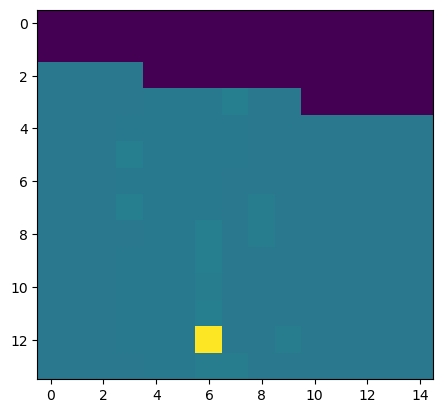

In [82]:
with open(LANDSAT_DATA_DIR / "cloud/abcx.npy", "rb") as f:
    img = np.load(f)
plt.imshow(np.transpose(img, axes=[1, 2, 0]))